# 千葉県 自転車盗難データ分析レポート

このレポートでは、千葉県警のオープンデータを利用し、  
過去1年間に発生した自転車盗難の傾向を分析した。

- どの地域で盗難が多いか  
- どの時間帯に多いか  
- 月ごとの発生件数  
- 鍵の有無で発生率はどう変わるか  
- 被害者の特徴（職業など）

などをPython（pandas / matplotlib）でまとめた。


In [7]:
import pandas as pd

df = pd.read_csv("jitensha.csv")
df.head()

,罪名,手口,管轄警察署（発生地）,管轄交番・駐在所（発生地）,市区町村コード（発生地）,都道府県（発生地）,市区町村（発生地）,町丁目（発生地）,発生年月日（始期）,発生時（始期）,発生場所,発生場所の詳細,被害者の年齢,被害者の職業,施錠関係
0,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240117,23,その他の住宅（３階建て以下共同住宅等）,駐車（輪）場,20歳代,大学生,施錠した
1,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240227,18,駐車（輪）場,駐車（輪）場,10歳代,中学生,施錠せず
2,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240528,20,駐車（輪）場,駐車（輪）場,40歳代,その他,施錠した
3,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240627,21,駐車（輪）場,駐車（輪）場,10歳代,中学生,施錠せず
4,窃盗,自転車盗,千葉中央,千葉寺駅前,121011.0,千葉県,千葉市中央区,青葉町,20240917,14,その他,その他,20歳代,その他,施錠せず


## 基本情報

データの行数・列数、欠損の有無などを確認する。


In [8]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9943 entries, 0 to 9942
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   罪名             9943 non-null   object 
 1   手口             9943 non-null   object 
 2   管轄警察署（発生地）     9943 non-null   object 
 3   管轄交番・駐在所（発生地）  9938 non-null   object 
 4   市区町村コード（発生地）   9942 non-null   float64
 5   都道府県（発生地）      9942 non-null   object 
 6   市区町村（発生地）      9942 non-null   object 
 7   町丁目（発生地）       9921 non-null   object 
 8   発生年月日（始期）      9943 non-null   object 
 9   発生時（始期）        9943 non-null   object 
 10  発生場所           9943 non-null   object 
 11  発生場所の詳細        9943 non-null   object 
 12  被害者の年齢         9943 non-null   object 
 13  被害者の職業         9943 non-null   object 
 14  施錠関係           9943 non-null   object 
dtypes: float64(1), object(14)
memory usage: 1.1+ MB


罪名                0
手口                0
管轄警察署（発生地）        0
管轄交番・駐在所（発生地）     5
市区町村コード（発生地）      1
都道府県（発生地）         1
市区町村（発生地）         1
町丁目（発生地）         22
発生年月日（始期）         0
発生時（始期）           0
発生場所              0
発生場所の詳細           0
被害者の年齢            0
被害者の職業            0
施錠関係              0
dtype: int64

## 市区町村ごとの盗難件数（多い順）


In [9]:
df.groupby('市区町村（発生地）').size().sort_values(ascending=False).head(10)


市区町村（発生地）
船橋市       1263
市川市        872
柏市         691
松戸市        678
千葉市中央区     656
八千代市       458
習志野市       450
浦安市        435
野田市        367
千葉市稲毛区     334
dtype: int64

## 月別の盗難件数


In [10]:
df['発生日'] = pd.to_datetime(df['発生年月日（始期）'], format="%Y%m%d", errors='coerce')
df['月'] = df['発生日'].dt.month

df.groupby('月').size()


月
1.0      620
2.0      569
3.0      681
4.0      761
5.0      813
6.0      826
7.0     1027
8.0      943
9.0      984
10.0     956
11.0     888
12.0     782
dtype: int64

## 鍵の有無による盗難件数の比較（Impact）


In [11]:
df.groupby('施錠関係').size()


施錠関係
施錠した    3162
施錠せず    6781
dtype: int64

## 発生時間帯の傾向


In [12]:
df.groupby('発生時（始期）').size().sort_values(ascending=False)


発生時（始期）
7     919
18    875
17    859
16    695
8     675
19    606
12    508
20    500
15    473
10    433
21    413
9     411
13    390
14    388
11    371
6     333
22    311
23    229
0     167
不明    115
5     113
1      74
2      32
4      30
3      23
dtype: int64

## 被害者の職業別の件数（上位10）


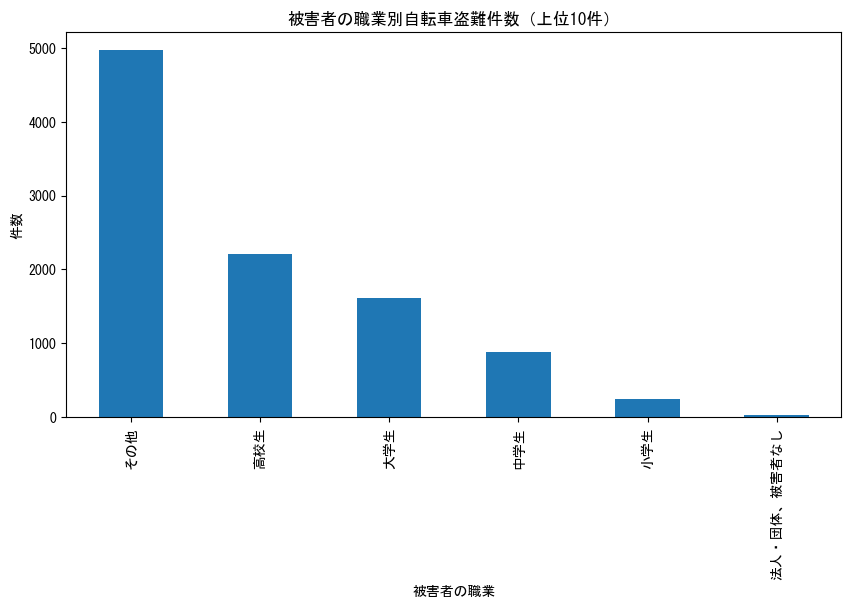

In [15]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'MS Gothic'

occupation_counts = df['被害者の職業'].value_counts().head(10)
occupation_counts.plot(kind='bar', figsize=(10,5))
plt.xlabel('被害者の職業')
plt.ylabel('件数')
plt.title('被害者の職業別自転車盗難件数（上位10件）')
plt.show()


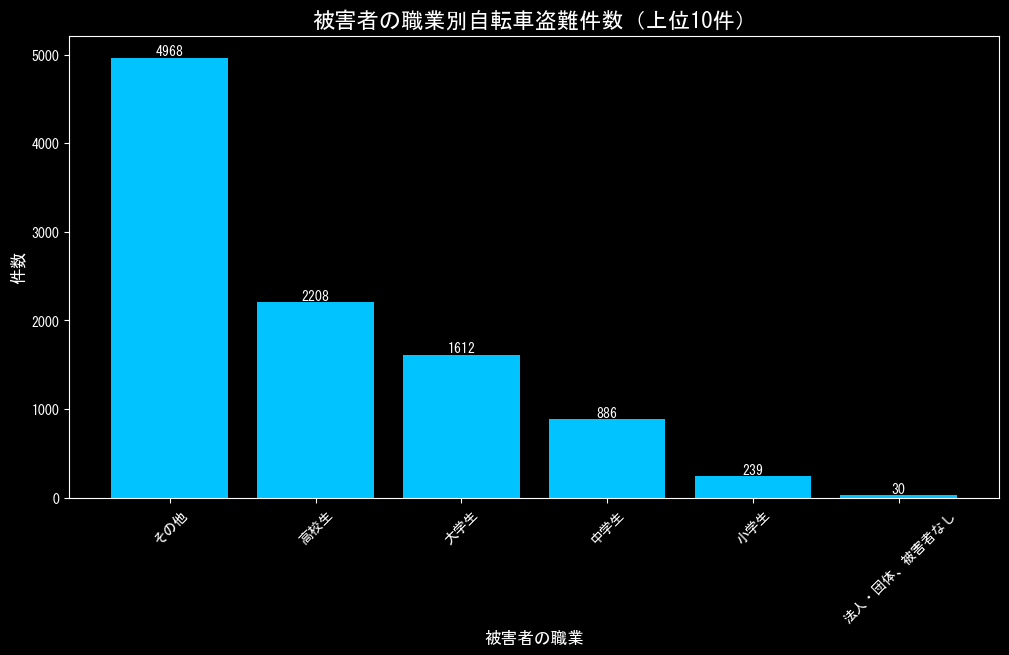

In [16]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')   # 黒背景

plt.rcParams['font.family'] = 'MS Gothic'

occupation_counts = df['被害者の職業'].value_counts().head(10)

plt.figure(figsize=(12,6))
bars = plt.bar(occupation_counts.index, occupation_counts.values, color='#00c3ff')

# 上に数字を表示
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{bar.get_height()}', ha='center', va='bottom', fontsize=10)

plt.title('被害者の職業別自転車盗難件数（上位10件）', fontsize=16, color='white')
plt.xlabel('被害者の職業', fontsize=12)
plt.ylabel('件数', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [20]:
monthly_counts = df.groupby('月').size().reset_index(name='件数')
monthly_counts.style.set_caption("月別自転車盗難件数").set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}
])


,月,件数
0,1.000000,620
1,2.000000,569
2,3.000000,681
3,4.000000,761
4,5.000000,813
5,6.000000,826
6,7.000000,1027
7,8.000000,943
8,9.000000,984
9,10.000000,956
